This notebook contains the code and analysis for analyzing the SciPlex dataset for coding assignment 1 in CS 582.

In [1]:
# Python standard library imports
import os
from random import seed
from collections import Counter

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Libraries for single-cell analysis
import anndata
import scanpy as sc

In [2]:
import scanpy as sc

In [3]:
RANDOM_SEED = 1234
seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
# View all columns of Pandas DataFrames:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Project Overview

In this project, we explore perturbation prediction in single-cell RNA sequencing (scRNAseq) data using Graph Neural Networks (GNNs) and explainability frameworks. The goal will be to perform accurate **perturbation prediction**, where we train a deep learning model, specifically a GNN, to predict the drug perturbation which was applied to a given cell based on its gene expression. Furthermore, in order to identify genes which contributed to or are responsible for model predictions, we utilize GNN explainability frameworks in order to explain GNN predictions and identify important features, nodes, and edges in the input graph. Additional discussion for the rationale of using GNNs for modeling single-cell data, as well as methodology are documented throughout this notebook.

Concretely, the goals will be to:
1. Train a Graph Neural Network to do drug perturbation prediction on scRNAseq data
2. Implement a GNN explainability framework to explain model predictions
3. Analyze important genes which factor into GNN predictions for specific drugs

The dataset we will be using will be the SciPlex dataset [1], which is a scRNAseq screening dataset consisting of 188 drug compounds applied to three different cell lines across thousands of samples. The sci-Plex methodology itself which enables the massive perturbational screening involves oligo nuclear hashing, which helps to quantify transcriptional responses to numerous independent perturbations at single-cell resolution. For the scope of this project, we will be using the A549 cancer cell line, which is a cell line of lung alveolus epithelial cells.

References:
1. Srivatsan, Sanjay R., et al. "Massively multiplex chemical transcriptomics at single-cell resolution." Science 367.6473 (2020): 45-51.

# Load Data

There are three cancerous cell lines in the sciPlex dataset: A549 (lung alveolus epithelial cells), K562 (cultured cells), and MCF7 (mammary gland).

We start by loading the annotated data object (anndata object) for the A549 cancer cell line. We see that it has many cell metadata and annotations in the .obs DataFrame, as well as information about the genomic features in the .var attribute.

In [5]:
PATH = "/home/sr2464/palmer_scratch/CS582_Coding_Assignment/SciPlexData/A549_lung_alveolus_epithelial_cell_culture.h5ad"
adata = anndata.read_h5ad(PATH)
adata

AnnData object with n_obs × n_vars = 143015 × 55773
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

In [6]:
adata.obs.head()

,sample,Size_Factor,n.umi,hash_umis_W,pval_W,qval_W,top_to_second_best_ratio_W,hash_umis_P,pval_P,qval_P,top_to_second_best_ratio_P,rt_well,lig_well,pcr_well,pcr_plate,rt_plate,lig_plate,Combo,well_oligo,plate_oligo,replicate,time_point,drug_dose,catalog_number,vehicle,dose_pattern,dose,pathway_level_1,pathway_level_2,product_name,target,pathway,product_dose,viability,num_genes_expressed,g1s_score,g2m_score,proliferation_index,Cluster,louvain_component,disease_ontology_term_id,donor_id,assay_ontology_term_id,tissue_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,is_primary_data,organism_ontology_term_id,suspension_type,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
A01_E09_RT_BC_100_Lig_BC_245,Chem3_Screen2,2.296651,3094,373,0.0,0.0,52.807724,209,0.000000e+00,0.000000e+00,56.814318,100,245,A01,E09,2,3,plate9_C3plate39,plate9_C3,plate39,rep2,24,S1055_2,S1055,False,2,1000,PKC signaling,PKC activitiy,Enzastaurin (LY317615),PKC,TGF-beta/Smad,Enzastaurin (LY317615)_1000,0.999924,1571,1.155964,2.475312,2.643512,1,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,+pQibXbkV6
A01_E09_RT_BC_100_Lig_BC_306,Chem3_Screen2,0.480141,646,23,0.0,0.0,10.053193,25,1.067310e-191,8.485111e-189,19.800273,100,306,A01,E09,2,4,plate10_D6plate40,plate10_D6,plate40,rep2,24,S1192_4,S1192,False,4,10,DNA damage & DNA repair,Nucleotide analog,Raltitrexed,DNA/RNA Synthesis,DNA Damage,Raltitrexed_10,0.997575,417,0.000000,1.980748,1.980748,2,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,5A~&6zx%%T
A01_E09_RT_BC_101_Lig_BC_109,Chem3_Screen2,0.516561,695,93,0.0,0.0,27.803759,117,0.000000e+00,0.000000e+00,43.313841,101,109,A01,E09,2,2,plate6_G5plate12,plate6_G5,plate12,rep1,24,S0002_3,S0000,True,3,0,Vehicle,Vehicle,Vehicle,Vehicle,Vehicle,Vehicle_0,1.000000,421,0.000000,0.000000,0.000000,2,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,pGI4g(d5me
A01_E09_RT_BC_101_Lig_BC_229,Chem3_Screen2,0.387978,523,75,0.0,0.0,63.947847,101,0.000000e+00,0.000000e+00,1886.909392,101,229,A01,E09,2,3,plate8_C5plate38,plate8_C5,plate38,rep2,24,S1029_4,S1029,False,4,10,Protein folding & Protein degradation,E3 ubiquitin ligase activity,Lenalidomide (CC-5013),TNF-alpha,Apoptosis,Lenalidomide (CC-5013)_10,0.999966,428,1.817254,2.801225,3.073606,7,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,G)G1o2fD<U
A01_E09_RT_BC_101_Lig_BC_280,Chem3_Screen2,0.724671,976,102,0.0,0.0,25.832608,127,0.000000e+00,0.000000e+00,475.679099,101,280,A01,E09,2,3,plate3_G1plate33,plate3_G1,plate33,rep2,24,S1703_2,S1703,False,2,1000,Epigenetic regulation,Histone deacetylation,Divalproex Sodium,HDAC,Ubiquitin,Divalproex Sodium_1000,0.953656,714,1.637016,0.867074,1.874835,10,2,PATO:0000461,A549,EFO:0030026,CL:0010003,CL:0000010,unknown,unknown,PATO:0000384,True,NCBITaxon:9606,nucleus,cell culture,cultured cell,sci-Plex,normal,Homo sapiens,male,epithelial cell of alveolus of lung,unknown,unknown,gY;lI#JE~o


In [7]:
Counter(adata.obs["cell_type"])

Counter({'cultured cell': 143015})

In [8]:
drug_perturbations_counter = Counter(adata.obs["product_name"])
print(len(drug_perturbations_counter))  # 189 drug compounds
drug_perturbations_counter

189


Counter({'Enzastaurin (LY317615)': 687,
         'Raltitrexed': 707,
         'Vehicle': 3287,
         'Lenalidomide (CC-5013)': 844,
         'Divalproex Sodium': 546,
         'MLN8054': 429,
         'Sodium Phenylbutyrate': 937,
         'Celecoxib': 802,
         'Linifanib (ABT-869)': 891,
         'Thalidomide': 780,
         'SNS-314': 528,
         '(+)-JQ1': 683,
         'S3I-201': 860,
         'AZD1480': 661,
         'PF-573228': 660,
         'CEP-33779': 894,
         'Resminostat': 750,
         'Tie2 kinase inhibitor': 905,
         'Nintedanib (BIBF 1120)': 947,
         'SRT3025 HCl': 549,
         'Avagacestat (BMS-708163)': 814,
         'Quisinostat (JNJ-26481585) 2HCl': 477,
         'MC1568': 713,
         'Temsirolimus (CCI-779, NSC 683864)': 559,
         'IOX2': 902,
         'Bosutinib (SKI-606)': 899,
         'Regorafenib (BAY 73-4506)': 761,
         'Aurora A Inhibitor I': 632,
         'ENMD-2076': 759,
         'Curcumin': 870,
         'NVP-BSK805 2

In [9]:
adata.var.head()

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length
feature_id,,,,,
ENSG00000278340,False,MIR6862-2,NCBITaxon:9606,gene,70
ENSG00000205328,False,OR6C65,NCBITaxon:9606,gene,939
ENSG00000237481,False,RP4-803J11.2,NCBITaxon:9606,gene,640
ENSG00000228118,False,MYL6P5,NCBITaxon:9606,gene,459
ENSG00000248245,False,CTB-49A3.2,NCBITaxon:9606,gene,816


In [10]:
# Switch index of .var attribute to gene names, make sure all gene names are capitalized
adata.var["gene_names"] = adata.var["feature_name"].astype(str).copy()
adata.var["gene_names"] = adata.var["gene_names"].apply(lambda x: x.upper())
adata.var["Ensembl_IDs"] = adata.var.index.copy()
adata.var.index = adata.var["gene_names"]

In [11]:
adata.var.head()

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,gene_names,Ensembl_IDs
gene_names,,,,,,,
MIR6862-2,False,MIR6862-2,NCBITaxon:9606,gene,70,MIR6862-2,ENSG00000278340
OR6C65,False,OR6C65,NCBITaxon:9606,gene,939,OR6C65,ENSG00000205328
RP4-803J11.2,False,RP4-803J11.2,NCBITaxon:9606,gene,640,RP4-803J11.2,ENSG00000237481
MYL6P5,False,MYL6P5,NCBITaxon:9606,gene,459,MYL6P5,ENSG00000228118
CTB-49A3.2,False,CTB-49A3.2,NCBITaxon:9606,gene,816,CTB-49A3.2,ENSG00000248245


In [12]:
adata.var.dtypes

feature_is_filtered        bool
feature_name           category
feature_reference      category
feature_biotype        category
feature_length         category
gene_names               object
Ensembl_IDs              object
dtype: object

In [13]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

Looking a bit more closely, we can see that the data has 143015 cells and 55773 genes. The cell x gene matrix, stored in the .X attribute, contains raw counts, which are integers representing how many RNA transcripts were captured for that gene in that particular cell.

In [14]:
adata

AnnData object with n_obs × n_vars = 143015 × 55773
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

In [15]:
adata.X.data[:10]  # Raw integer counts of RNA transcripts

array([1., 1., 1., 1., 1., 4., 1., 1., 1., 1.], dtype=float32)

# Data preprocessing and visualization

Since the data we loaded is unprocessed, we will need to perform standard filtering and normalization steps in order to preprocess the scRNAseq data before we can train Machine Learning models on it. We will follow a great preprocessing and data visualization guide from the Scanpy library:

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [16]:
# Basic filtering of cells with too few genes expressed and genes expressed in too few cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [17]:
adata  # We can see that a few cells and a few thousand genes were filtered out

AnnData object with n_obs × n_vars = 142944 × 33015
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

In [18]:
# Filtering cells by statistics about mitochondrial gene counts. Follows intuition that healthy cells should not have
# a high proportion of counts coming from mitochondrial genes
#  annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [19]:
adata

AnnData object with n_obs × n_vars = 142944 × 33015
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

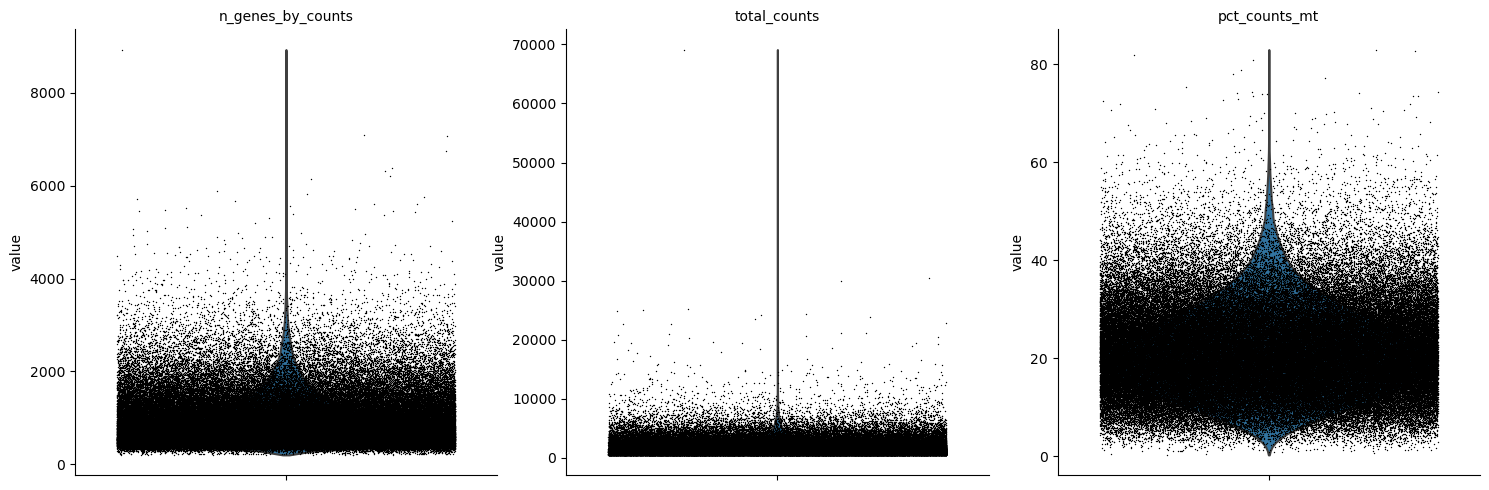

In [20]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True
)

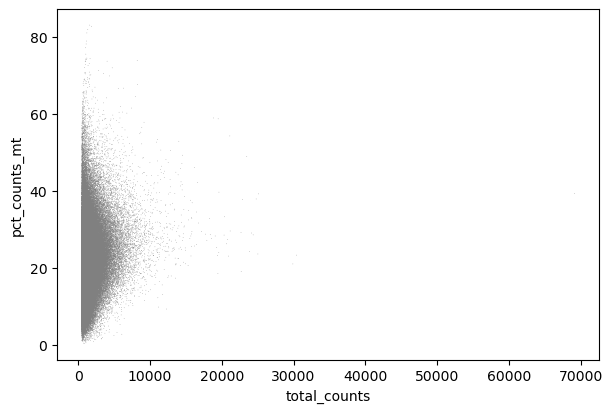

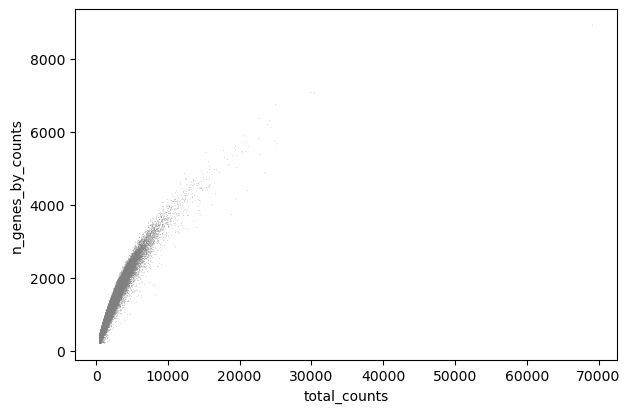

In [21]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

From the plots, we can see that there are outlier cells which have n_genes_by_counts > 4000, and which have over 60 percent of their counts coming from mitochondrial genes, which is too high for normal cells. We therefore filter them out.

In [22]:
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 60, :].copy()

In [23]:
adata

AnnData object with n_obs × n_vars = 142630 × 33015
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

Now we normalize all counts to sum up to 10000 for all cells, so that counts become comparable across cells

In [24]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [27]:
adata.X.data.shape

(133751800,)

A quick peek at the nonzero values in our data tells us that things are heavily exponentially distributed, so we do a log normalization on the entire cell x gene matrix. We do log1p so that zero counts stay as zero after the log transformation.

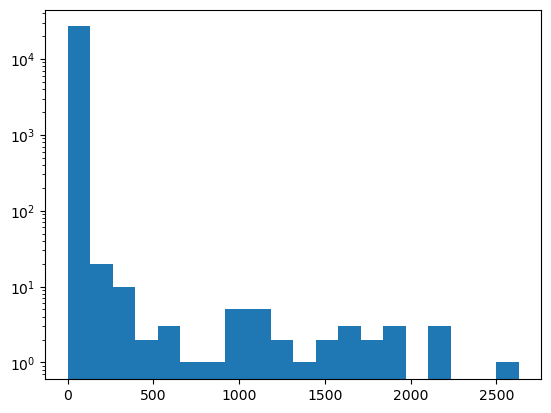

In [28]:
plt.hist(adata.X.data[::5000], bins=20)
plt.yscale("log")
plt.show()
plt.close()

In [29]:
sc.pp.log1p(adata)

Our data is now in a better range after log transformation, however it is still not in a great range for neural networks. We add on an additional step here of min-max normalization to bring the expression into range [0, 1].

We know, however, that there can be outlier values in the expression, as seen in our filtering steps. We want the majority of our data to fall into the [0,1] range with good density, so we can normalize by the 99.9th percentile rather than the 100th percentile, so that outliers do not push our value range to become too small.

In [30]:
print(adata.X.max())
print(adata.X.min())

8.482397
0.0


In [37]:
ninety_ninth = np.percentile(adata.X.data, 99.0)
print("ninety_ninth:", ninety_ninth)
print("max value:", adata.X.data.max())

ninety_ninth: 0.575293779373169
max value: 1.3019904


In [34]:
# adata.X is a sparse matrix, and the minimum value in the matrix is 0, so it will be sufficient to divide the .data attribute of the 
#  sparse matrix in order to scale into relative [0, 1] range
adata.X.data /= ninety_ninth
print("max value:", adata.X.data.max())

max value: 1.3019904


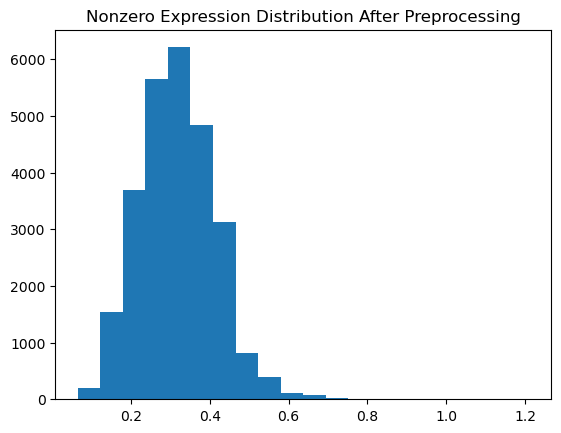

In [36]:
plt.hist(adata.X.data[::5000], bins=20)
plt.title("Nonzero Expression Distribution After Preprocessing")
plt.show()
plt.close()

We can see that after our preprocessing steps, we have a nice normal distribution of values prmarily in the range [0, 1], but not biased by outliers. This will be good as input for our GNN later on. We will save the preprocessed anndata object in a specific variable for later input into our GNN model. The adata we have currently will continue to be modified for visualization purposes.

In [40]:
preprocessed_adata_cp10k_log1p_minmax = adata.copy()
preprocessed_adata_cp10k_log1p_minmax

AnnData object with n_obs × n_vars = 142630 × 33015
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 

We now continue with the Scanpy tutorial, which contains a few more useful visualization and calculation steps

In [38]:
# Finding highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

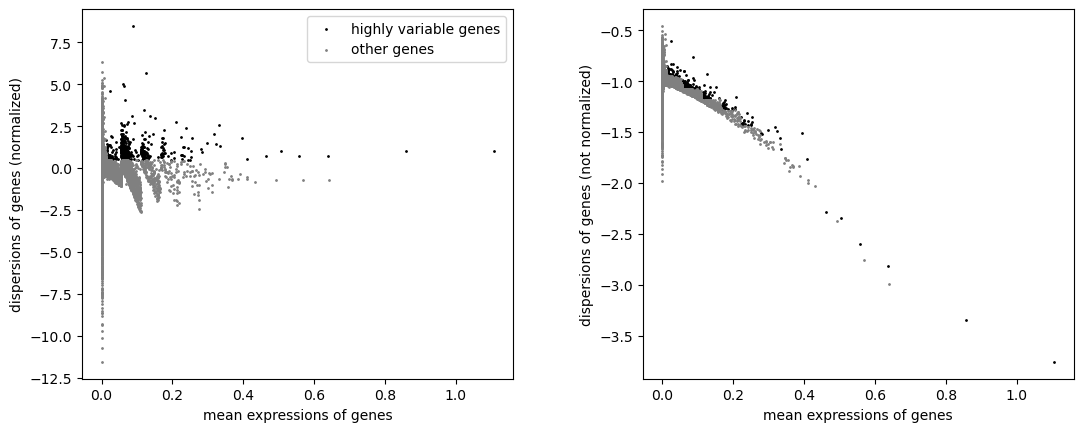

In [41]:
sc.pl.highly_variable_genes(adata)

In [42]:
# For visualization, we will be plotting things only using highly variable genes. Filter to HVGs here:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 142630 × 553
    obs: 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'time_point', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'Cluster', 'louvain_component', 'disease_ontology_term_id', 'donor_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', '

In [44]:
# Here we regress out the effects of total_counts and mitochondrial gene percentage expressed, and we scale the
#  data to zero mean and unit variance before computing PCA
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

In [45]:
# Calculate PCA on data
sc.tl.pca(adata, svd_solver="arpack")

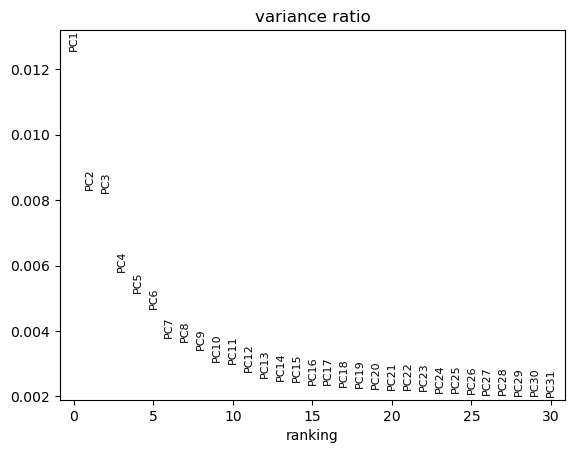

In [46]:
sc.pl.pca_variance_ratio(adata, log=False)

In [47]:
# Compute a neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/vast/palmer/home.mccleary/sr2464/.conda/envs/pyg_torch2.1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we plot a UMAP of the data, colored by drug perturbation compound

In [48]:
sc.tl.umap(adata)

KeyboardInterrupt: 

In [ ]:
sc.pl.umap(adata, color=["product_name"])